In [308]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import MeCab
import emoji as Emoji

In [309]:
from sequence import Sequence
from load_emojis import load_emojis

In [310]:
mecab = MeCab.Tagger("-Owakati")
wakati = mecab.parse("坂本ですが").split()
print(wakati)

['坂本', 'です', 'が']


In [326]:
def read_data():
  """Get data from MongoDB as a list of words"""
  #   with zipfile.ZipFile(filename) as f:
  #     data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  #   return data
  words = list()
  for sequence in Sequence.objects:
    words.extend(mecab.parse(sequence.content).split())
  return words
    
words = read_data()
print('Data size %d' % len(words))
print(words[:20])

Data size 225209
['筋', 'トレガンバ', '💪', '載せる', '😻', 'さき', 'な', 'おめでとう', '💓', '毎日', 'パイン', 'ジュース', '飲ん', 'でる', 'さき', 'な', 'ちゃん', 'たま', 'に', 'は']


In [327]:
vocabulary_size = 20000
emojis = load_emojis()

def build_dataset(words):
  count = [['UNK', -1]]
#   count.extend([[emoji, -1] for emoji in emojis])
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  #for emoji in emojis:
  #  dictionary[emoji] = len(dictionary)
  for word, _ in count:
    if word not in emojis:
      dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
# for emoji in emojis[:10]:
#   print((emoji, dictionary[emoji]), end=", ")

# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 27525], ('て', 5620), ('た', 4283), ('の', 4148), ('に', 3829)]
Sample data [5767, 14193, 0, 8379, 0, 1089, 12, 48, 0, 571]


In [328]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['筋', 'トレガンバ', 'UNK', '載せる', 'UNK', 'さき', 'な', 'おめでとう']

with num_skips = 2 and skip_window = 1:
    batch: ['トレガンバ', 'トレガンバ', 'UNK', 'UNK', '載せる', '載せる', 'UNK', 'UNK']
    labels: ['筋', 'UNK', '載せる', 'トレガンバ', 'UNK', 'UNK', 'さき', '載せる']

with num_skips = 4 and skip_window = 2:
    batch: ['UNK', 'UNK', 'UNK', 'UNK', '載せる', '載せる', '載せる', '載せる']
    labels: ['トレガンバ', 'UNK', '筋', '載せる', 'さき', 'UNK', 'UNK', 'トレガンバ']


In [329]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [330]:
num_steps = 100001
print(len(reverse_dictionary))
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0

  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k): 
          if nearest[k] < len(reverse_dictionary):
            close_word = reverse_dictionary[nearest[k]]
          else:
           close_word = nearest[k]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

19623
Initialized
Average loss at step 0: 7.286068
Nearest to から: 🌞🌈💭, お世話, /☝, ❤&, 🐇💛🐇💛🐇💛🐇💛🐇💛🐇💛🐇💛, つられ, っていう, 死亡,
Nearest to RT: 集合, (’, Go, 保土ヶ谷, さくら, 《, つられ, 😂💭💘,
Nearest to わ: 人声, つんと, 魔法, 羽根, 😭😭😭😭😭, 😮💭, 😮💟, 辛抱,
Nearest to そう: ✪∀✪, 💛💛, 人達, 訳, ディアルガ, てき, ｷｭﾝｷｭﾝﾊﾝﾊﾟﾅｲﾃﾞｽ, 解禁,
Nearest to まし: 落ち着く, 無, ´)❤, 英語, ゃぁない, 会わ, ㅤㅤㅤㅤ🌸, とまる,
Nearest to UNK: 橘, ウエスト, サウンド, 新規, .......................／＞, 揃う, INOkinawa, やすみ,
Nearest to けど: 🤘💗, ༎ຶ, 酔い, レモン, 高田, 慶一郎, 🎇👘, 💗👻,
Nearest to 可愛い: ディアルガ, 🎤💭, 土曜日, ≡(＃｀, ビジュ, ２1, 線, 》|,
Nearest to .: 遠慮, ウケ, 納豆, 遠慮なく, こんばんは, ≡⊂(^-^)⊃, キャンドル, 構造,
Nearest to ): 迷わ, 抵抗, Ohnooooooo, やり方, くみ, 清末, 🍚🍰, ぜ,
Nearest to 年: 👕👕, ˊᗜˋ, 🗣💕, 軽率, わくわく, はみ, 甘酸っぱい, Д,
Nearest to ます: 願, ビースタ, 合宿, ハレルヤチャーンス, 大笑い, 裏, 🌹🤑, 👽🍥🔥,
Nearest to さ: カラコンナチュラル, 把, ゆめ, 💐💘, ホームラン, ☁☁☁, ∗), (*^∇^*),
Nearest to 、: はろ, 世の中, 恨む, 本心, ??✋, (*'-'*), 乗り, ぁんおる,
Nearest to て: ペン, づらく, 混み, 回復, TYPE, 寝違え, お天気, funky,
Nearest to って: ;✌, 付き合う, 88, SALE, make, 着, FJK, はじめる,
Average loss at step 2000: 3.992972

In [331]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

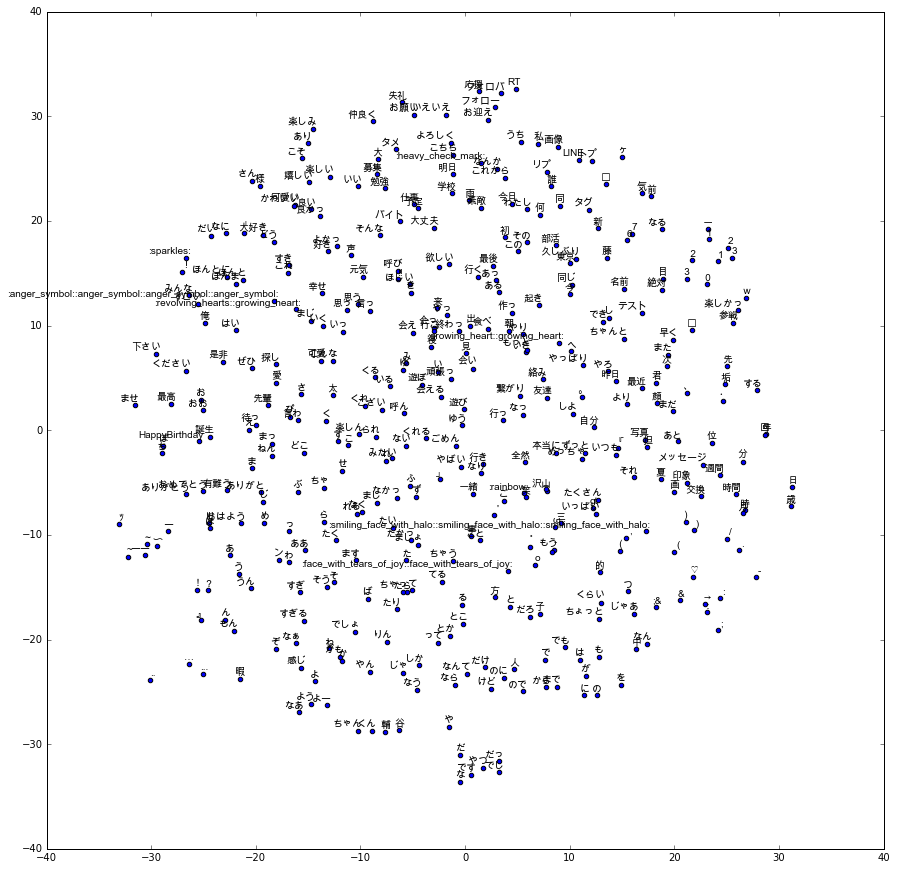

In [332]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='/Library/Fonts/Arial Unicode.ttf');

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(Emoji.demojize(label), xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom', fontproperties = fp)
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)